# 6.1 Classification Models

![blr](../../images/blr.jpeg)

## 6.1.1 Binary Models. Churn Example

Al hablar de modelos de clasificación binarios estamos hablando de modelos en los que nuestra variable dependiente es categórica y únicamente tiene dos clases a predecir, uno de los ejemplos más claros de este tipo de modelos son los problemas de 'Churn' o lo que es lo mismo la retención de clientes por parte de las compañías, y más que la retención es la detección temprana de si un cliente se va a ir de nuestra compañía o no. Suelen ser problemas complejos ya que la clase a predecir suele estar muy desbalanceada, ya que lo normal es que los clientes no se vayan de la compañía.

![churn](../../images/churn.png)


![churn2](../../images/churn2.png)


### **Regresión Logística**

In [1]:
import pandas as pd                                # panel data, for handling dataframes
pd.set_option('display.max_columns', None)         # show all columns of the dataframe

import numpy as np                                 # numerical python, linear algebra library

import pylab as plt                                # plotting library
import seaborn as sns                              # plotting library
sns.set(style='white')                             # seaborn style


from sklearn.linear_model import LogisticRegression            # logistic regression model   

from sklearn.preprocessing import MinMaxScaler                 # standarized
from sklearn.preprocessing import LabelEncoder                 # Para codificar nuestra variable a predecir

from sklearn.model_selection import train_test_split     # split data into train and test sets

import warnings
warnings.filterwarnings('ignore')

Comenzaremos por explicar el modelo de regresión logisitica, modelo básico utilizado para clasificar, se basa en minimizar los pesos de la función sigmoide.

![sig_plot](../../images/sig_plot.png)

Básicamente la función tratará de ajustarse para separar nuestros datos en dos grupos los que se encuentren a la izq de la función perteneceran a una clase, y los de la derecha a la otra.

#### Carga de datos

In [2]:
df=pd.read_csv('../../../data/churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthLevel,TotalLevel,TenureLevel,ChurnBinary
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Low,Very Low,New,0.0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Low,Moderate,Loyal,0.0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Low,Very Low,New,1.0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Low,Moderate,Loyal,0.0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Moderate,Very Low,New,1.0


#### EDA

In [3]:
df.shape

(7032, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [5]:
df.Churn.value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [6]:
df.ChurnBinary.value_counts()

0.0    5163
1.0    1869
Name: ChurnBinary, dtype: int64

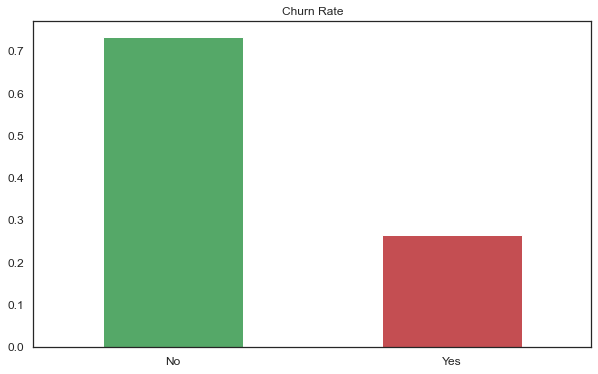

In [7]:
(df.Churn.value_counts()/len(df)).plot.bar(color=['g', 'r'],    # plot customer churn rate
                                           figsize=(10, 6),
                                           title='Churn Rate',
                                           rot=0,
                                           fontsize=12);

In [8]:
df.Churn.value_counts(normalize=True)

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

#### Transformaciones

Tenemos varias opciones, podríamos tratar de crear un modelo únicamente con las variables numéricas que tenemos y ver cual es su desempeño, sería el modelo más simple y el que menos coste tendría, podríamos proponer alguna serie de transformaciones de las columnas categóricas y numéricas para poder realizar varios experimentos, pero para el caso que nos compete, realizaremos una transformación con label Enconder.

##### Variables categóricas

**Label Encoder**

In [9]:
le = LabelEncoder()

In [10]:
df_le = df.copy()
for c in df.columns:
    
    if df_le.dtypes[c]==object and (c != 'customerID' or c != 'Churn'):
        
        le.fit(df_le[c].astype(str))
        
        df_le[c]=le.transform(df_le[c].astype(str))

In [11]:
df_le

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthLevel,TotalLevel,TenureLevel,ChurnBinary
0,5365,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0,1,4,1,0.0
1,3953,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0,1,2,0,0.0
2,2558,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,1,4,1,1.0
3,5524,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0,1,2,0,0.0
4,6500,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,2,4,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,4843,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50,0,0,2,0,0.0
7028,1524,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90,0,3,3,3,0.0
7029,3358,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45,0,1,1,1,0.0
7030,5923,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1,2,1,1,1.0


##### Variables numéricas

Al igual que nos pasaba con las variables categóricas debemos de decidir que hacemos con las variables numéricas, debemos ver si estandarizamos los datos o no, para ello nos fijaremos en la descripción de nuestros datos estadísticos.

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
ChurnBinary,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00


In [13]:
df_le.describe().T

,count,mean,std,min,25%,50%,75%,max
customerID,7032.0,3515.500000,2030.107879,0.00,1757.7500,3515.500,5273.2500,7031.00
gender,7032.0,0.504693,0.500014,0.00,0.0000,1.000,1.0000,1.00
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
Partner,7032.0,0.482509,0.499729,0.00,0.0000,0.000,1.0000,1.00
Dependents,7032.0,0.298493,0.457629,0.00,0.0000,0.000,1.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
PhoneService,7032.0,0.903299,0.295571,0.00,1.0000,1.000,1.0000,1.00
MultipleLines,7032.0,0.940557,0.948627,0.00,0.0000,1.000,2.0000,2.00
InternetService,7032.0,0.872582,0.737271,0.00,0.0000,1.000,1.0000,2.00
OnlineSecurity,7032.0,0.789249,0.859962,0.00,0.0000,1.000,2.0000,2.00


Como la mayoría de nuestros datos están entre 0 y 1 podemos usar el MinMaxScaler para transformar las columnas.

**Antes de aplicar las transformaciones realizamos el train test split**

Al igual que en los modelos de regresión antes de realizar las transformaciones para estandarizar los datos haremos el train test split. En el caso de que tuvieramos varios experimentos deberíamos de hacerlel tts para cada uno de nuestros dataframes propuestos para realizar los experimentos. Y para cada uno de ellos deberíamos de entrenar un escaler diferente.

In [14]:
X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(df_le.drop(['customerID', 'Churn', 'ChurnBinary'], axis=1), df_le.Churn, random_state=42, test_size=.2, 
                                                    stratify=df_le.Churn)

In [15]:
mm_le = MinMaxScaler().fit(X_train_le)


In [16]:
X_train_le = mm_le.transform(X_train_le)
X_test_le = mm_le.transform(X_test_le)

In [17]:
y_train_le.value_counts(), y_test_le.value_counts()

(0    4130
 1    1495
 Name: Churn, dtype: int64,
 0    1033
 1     374
 Name: Churn, dtype: int64)

#### Modelo

Lo primero que tenemos que hacer es inicializar nuestro modelo

In [18]:
logreg_le = LogisticRegression(max_iter=2000)

In [19]:
logreg_le.fit(X_train_le, y_train_le)
score_train = logreg_le.score(X_train_le, y_train_le)
score_test = logreg_le.score(X_test_le, y_test_le)
        
res_num = {'le_train_score': score_train,
                   'le_test_score': score_test}

In [20]:
res_num

{'le_train_score': 0.8048, 'le_test_score': 0.7967306325515281}

Parece ser que tenemos un buen resultado pero el accuracy en modelos de clasificación no es la mejor métrica de evaluación

##### Evaluación

**Matriz de confusión**

![conf_matrix](../../images/conf_matrix.jpeg)

+ TP := True Positive (aciertos clase 1)
+ TN := True Negative (aciertos clase 0)
+ FP := False Positive (Error tipo I, decir 1 cuando es 0)
+ FN := False Negative (Error tipo II, decir 0 cuando es 1)

+ Accuracy  := (TP+TN)/(TP+TN+FP+FN) (acierto)  ($\frac{1}{n}\sum 1(\hat{y_i}=y_i$))
+ Precision := TP/(TP+FP)
+ Recall    := TP/(TP+FN)  (Sensibilidad, TPR)
+ F1_Score  := 2·Recall·Precision/(Recall+Precision)

(F1 funciona mejor que el accuracy cuando los datos no están balanceados y cuando FP y FN son muy diferentes)

![f1](../../images/f1.png)

In [21]:
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score

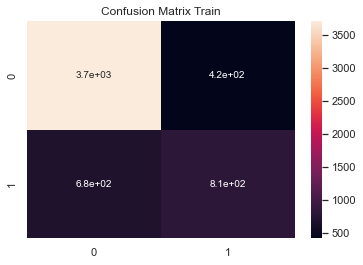

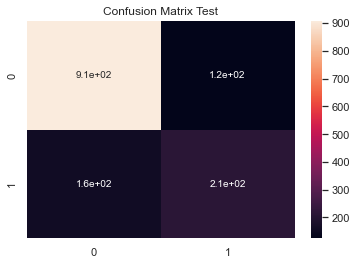

In [22]:
logreg_le.fit(X_train_le, y_train_le)
score_train = logreg_le.score(X_train_le, y_train_le)
score_test = logreg_le.score(X_test_le, y_test_le)
precision_train = precision_score(y_train_le, logreg_le.predict(X_train_le))
precision_test = precision_score(y_test_le, logreg_le.predict(X_test_le))
recall_train = recall_score(y_train_le, logreg_le.predict(X_train_le))
recall_test = recall_score(y_test_le, logreg_le.predict(X_test_le))
f1_train = f1_score(y_train_le, logreg_le.predict(X_train_le))
f1_test = f1_score(y_test_le, logreg_le.predict(X_test_le))
        
res_num = {'le_train_score': score_train,
           'le_test_score': score_test,
           'le_train_precision': precision_train,
           'le_test_precision': precision_test,
           'le_train_recall': recall_train,
           'le_test_recall': recall_test,
           'le_f1_train': f1_train,
           'le_f1_test': f1_test}
        
sns.heatmap(confusion_matrix(y_train_le, logreg_le.predict(X_train_le)), annot=True)
plt.title('Confusion Matrix Train')
plt.show();
sns.heatmap(confusion_matrix(y_test_le, logreg_le.predict(X_test_le)), annot=True)
plt.title('Confusion Matrix Test')
plt.show();

In [23]:
res_num

{'le_train_score': 0.8048,
 'le_test_score': 0.7967306325515281,
 'le_train_precision': 0.661251015434606,
 'le_test_precision': 0.6301775147928994,
 'le_train_recall': 0.5444816053511705,
 'le_test_recall': 0.56951871657754,
 'le_f1_train': 0.5972120322817315,
 'le_f1_test': 0.5983146067415729}

Como vemos nuestro modelo no está funcionando muy correctamente, y esto es debido a que nuestros datos están muy desbalanceados, y nuestro modelo tiene un sesgo, básicamente está diciendo a todo que no, a parte está ligeramente overfitteado, esto podemos verlo en los resultados de train y test, ya que el f1 score en test es ligeramente superior que en train.
Para tratar de compensar este tipo de incovenientes tenemos diferentes técnicas de balanceo

#### Balanceo

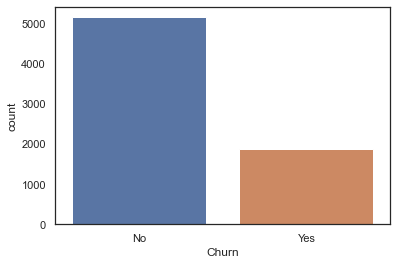

In [24]:
sns.countplot(df.Churn);

Cuando la variable objetivo está desbalanceada, tenemos varias opciones para tratar de balancear los datos:

    - Métodos de undersampling
    - Métodos de oversampling
 
Elegiremos uno u otro método en base al número de datos de los que dispongamos, si disponemos un gran volumen de datos podemos decantarnos por técnicas de undersamplig en las que básicamente nos quedaremos con el mayor número de datos de la clase minoritaria, y tomaremos un sample de la misma longitud de la clase mayoritaria.

Para los métodos de oversampling tenemos dos métodos:

    - Random Oversampling: Con esta técnica el algoritmo genera datos nuevos de forma aleatoria basándose en los datos que le pasamos, hasta igualar ambas clases.
    
    - Smote: Este método es similar con la salvedad de que los datos generados de forma aleatoria se generan siguiendo una distribución normal.

In [25]:
#!pip install -U imbalanced-learn

In [26]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [27]:
smote = SMOTE()
rov = RandomOverSampler()

**Es importante tener en cuenta que solo aplicaremos la técnica de Oversampling o Undersampling a los datos de entrenamiento, los datos de test no se tocan.**

In [28]:
X_train_le_sm, y_train_le_sm = smote.fit_resample(X_train_le, y_train_le)


In [29]:
X_train_le_sm.shape, y_train_le_sm.shape

((8260, 22), (8260,))

In [30]:
y_train_le_sm.value_counts()

0    4130
1    4130
Name: Churn, dtype: int64

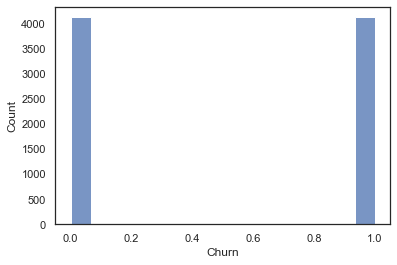

In [31]:
sns.histplot(y_train_le_sm);

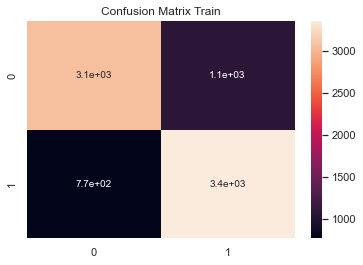

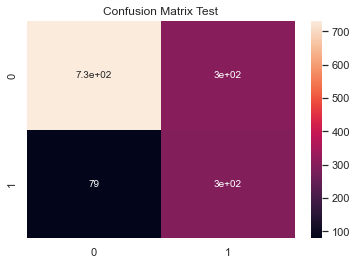

In [32]:
logreg_le.fit(X_train_le_sm, y_train_le_sm)
score_train_sm = logreg_le.score(X_train_le_sm, y_train_le_sm)
score_test_sm = logreg_le.score(X_test_le, y_test_le)
precision_train_sm = precision_score(y_train_le_sm, logreg_le.predict(X_train_le_sm))
precision_test_sm = precision_score(y_test_le, logreg_le.predict(X_test_le))
recall_train_sm = recall_score(y_train_le_sm, logreg_le.predict(X_train_le_sm))
recall_test_sm = recall_score(y_test_le, logreg_le.predict(X_test_le))
f1_train_sm = f1_score(y_train_le_sm, logreg_le.predict(X_train_le_sm))
f1_test_sm = f1_score(y_test_le, logreg_le.predict(X_test_le))
        
res_sm = {'le_train_sm_score': score_train_sm,
          'le_test_sm_score': score_test_sm,
          'le_train_precision': precision_train_sm,
          'le_test_precision': precision_test_sm,
          'le_train_recall': recall_train_sm,
          'le_test_recall': recall_test_sm,
          'le_f1_train_sm': f1_train_sm,
          'le_f1_test_sm': f1_test_sm}
        
sns.heatmap(confusion_matrix(y_train_le_sm, logreg_le.predict(X_train_le_sm)), annot=True);
plt.title('Confusion Matrix Train')
plt.show();
sns.heatmap(confusion_matrix(y_test_le, logreg_le.predict(X_test_le)), annot=True);
plt.title('Confusion Matrix Test')
plt.show();

In [33]:
res_sm

{'le_train_sm_score': 0.7772397094430993,
 'le_test_sm_score': 0.7292110874200426,
 'le_train_precision': 0.7585817524841915,
 'le_test_precision': 0.49413735343383586,
 'le_train_recall': 0.8133171912832929,
 'le_test_recall': 0.7887700534759359,
 'le_f1_train_sm': 0.7849964945080626,
 'le_f1_test_sm': 0.6076210092687951}

#### Selección de Variables y reentreno de modelo

Como podemos oberservar el modelo ha mejorado un poco y se ha corregido el overfitting, llegados a este punto podemos valorar varias opciones o bien realizar un análisis más profundo de los datos y ver como están correlacionados nuestros datos en busca de colinealidad, realizar un estudio estudio de importancia de características, ajustar punto donde queremos valorar que un resultado sea Churn en la regresión logística, o cambiar de modelo.
Antes de cambiar de modelo vamos a probar a ajustar el punto de intersección de la regresión logística y evaluar los coeficientes de cada una de las características y su correlación en busca de colinealidad.

In [34]:
logreg_le.intercept_

array([-0.07950253])

In [35]:
coefs = dict(zip(list(df_le.drop(['customerID', 'Churn', 'ChurnBinary'], axis=1).columns),list(logreg_le.coef_[0])))

In [36]:
coefs

{'gender': 0.010739224084883807,
 'SeniorCitizen': 0.08308132633391932,
 'Partner': 0.04121965142491565,
 'Dependents': -0.3379104631763143,
 'tenure': -2.4126235467211123,
 'PhoneService': -1.0639975799933705,
 'MultipleLines': 0.2141194795686736,
 'InternetService': 0.5302547023730669,
 'OnlineSecurity': -0.5864603930694705,
 'OnlineBackup': -0.3034606383399855,
 'DeviceProtection': -0.09695101088540467,
 'TechSupport': -0.50752480226184,
 'StreamingTV': -0.05215700768582379,
 'StreamingMovies': 0.0564046585418464,
 'Contract': -1.8530649930820027,
 'PaperlessBilling': 0.3742550240761304,
 'PaymentMethod': 0.36838559062917864,
 'MonthlyCharges': 2.9684073434682676,
 'TotalCharges': 0.5082127847928649,
 'MonthLevel': 0.12176825854742242,
 'TotalLevel': 0.6934470956237898,
 'TenureLevel': 0.01524089513716897}

Vamos a interpretar estos coeficientes, también denominados R statistic.

Un valor positivo significa que al crecer la variable predictora, lo hace la probabilidad de que el evento ocurra. Un valor negativo implica que si la variable predictora decrece, la probabilidad de que el resultado ocurra disminuye. Si una variable tiene un valor pequeño de R entonces esta contribuye al modelo sólo una pequeña cantidad.

De esto podemos extraer que si quitamos todas las columnas con un coeficiente negativo, nuestro modelo podría mejorar.

In [37]:
neg_coef = []

for k,v in coefs.items():
    if v < 0:
        neg_coef.append(k)
neg_coef

['Dependents',
 'tenure',
 'PhoneService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'Contract']

In [38]:
df_le_pos_coef = df_le.drop(neg_coef+['customerID','ChurnBinary'], axis=1)

df_le_pos_coef.head()

,gender,SeniorCitizen,Partner,MultipleLines,InternetService,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthLevel,TotalLevel,TenureLevel
0,0,0,1,1,0,0,1,2,29.85,29.85,0,1,4,1
1,1,0,0,0,0,0,0,3,56.95,1889.50,0,1,2,0
2,1,0,0,0,0,0,1,3,53.85,108.15,1,1,4,1
3,1,0,0,1,0,0,0,0,42.30,1840.75,0,1,2,0
4,0,0,0,0,1,0,1,2,70.70,151.65,1,2,4,1


También comprobaremos la correlación de nuestas columnas restantes en busca de posible colinealidad entre ellas

In [39]:
def print_heatmap_corr(data:pd.DataFrame, annot:bool=True, cmap:str=None, 
                       mask:bool=True, save:bool=False, title:str=None)->None:
    
    '''
        Función que recibe un dataframe y devuelve la matriz de correlación en forma de mapa de color
        
        Parameters:
        -----------
        
        data: Dataset sobre el que queremos realizar la matriz de correlación
        annot: Si queremos mostrar el valor de la correlación en la matriz, default = True
        cmap: Paleta de colores que queremos usar para nuestro heatmap
        mask: Parámetro para mostrar solo la triangular inferior de la matriz de correlación
        save: Parámetro para salvar nuestro gráfico
        title: Título que queremos que lleve nuestro gráfico
    '''
    
    sns.set(style='white')     # estilo blanco hace que el fondo de la matriz sea transparente

    if mask: # Si mask es True
        mascara=np.triu(np.ones_like(data.corr(), dtype=bool))   # genera una mascara para tapar valores
    else:
        mascara = None # No aplicamos máscar

    if cmap: # Si le hemos pasado una paleta de colores
        c_map = sns.color_palette(cmap, as_cmap=True)
    else:
        c_map=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de colores por defecto

    plt.figure(figsize=(20,15))
    p = sns.heatmap(data.corr(), # aplica el método corr() a nuestro dataset
            mask=mascara, # aplica la mascara
            cmap=c_map, # aplica la paleta de colores
            vmax=1, # para establecer el valor máximo de valores
            center=0, # establece el centro de la paleta de colores
            square=True,
            linewidth=0.5, # para aplicar borde a los cuadros de la matriz
            cbar_kws={'shrink': 0.5}, # mostrar leyenda de colores
            annot=annot # mostrar valores de la matriz
           )
    p.set_title(title, fontsize=20)
    
    if save:
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();

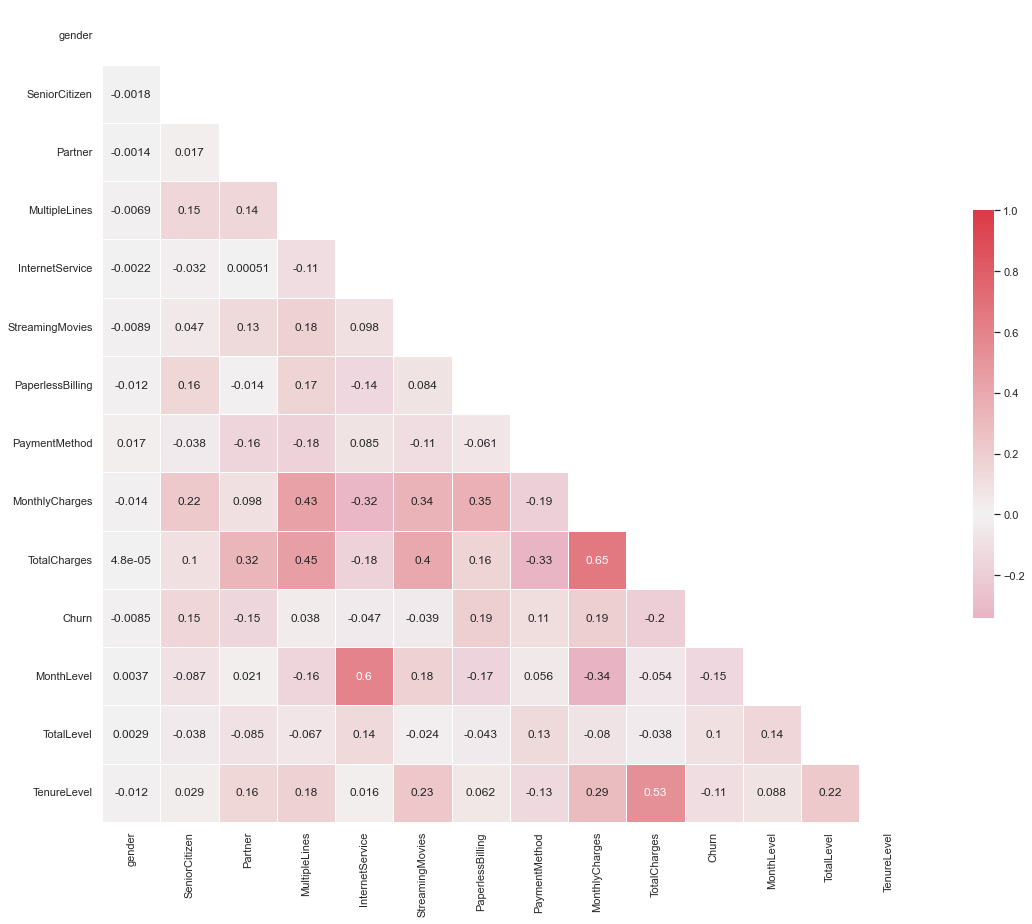

In [40]:
print_heatmap_corr(df_le_pos_coef)

Vemos que la las variables independientes no tienen mucha correlación con nuestra variable dependiente, esto quiere decir que la solución al problema es compleja y hay que tratarla con cuidado, y también puede darnos una indicación de que los resultados que podemos esperar de los modelos no van ha ser muy buenos, pero tenemos que tratar de hacer todo lo posible para que estos sean lo más altos posibles.
Respecto a la correlación entre las variables independientes vemos que salvo TotalCharges no hay excesiva colinealidad entre nuestras variables, por lo que nos quedaremos con ellas.

Como nuestro set de datos es diferente al original debemos de volver a realizar el train_test_split de nuevo, junto con el scaler y el smote para corregir el balanceo.

Declararemos de nuevo nuestras X e y y aplicamos todo el proceso de transformaciones.

In [41]:
X = df_le_pos_coef.drop('Churn', axis=1)
y = df_le_pos_coef.Churn

X.shape, y.shape

((7032, 13), (7032,))

**Primero hacemos train test split de nuevo**

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2, stratify=y)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 13), (1407, 13), (5625,), (1407,))

**Seguidamente aplicamos el escalado**

In [44]:
mm = MinMaxScaler().fit(X_train)

In [45]:
X_train = mm.transform(X_train)
X_test = mm.transform(X_test)

**Aplicamos SMOTE**

In [46]:
smote = SMOTE()

In [47]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [48]:
X_train.shape, y_train.shape

((8260, 13), (8260,))

In [49]:
y_train.value_counts()

0    4130
1    4130
Name: Churn, dtype: int64

**Inicializamos un modelo nuevo y lo entrenamos**

In [50]:
lr = LogisticRegression(max_iter=2000)

In [51]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

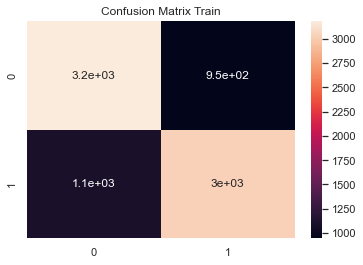

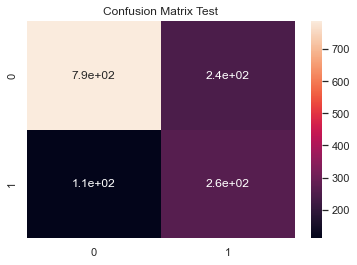

In [52]:
score_train = lr.score(X_train, y_train)
score_test = lr.score(X_test, y_test)
precision_train = precision_score(y_train, lr.predict(X_train))
precision_test = precision_score(y_test, lr.predict(X_test))
recall_train = recall_score(y_train, lr.predict(X_train))
recall_test = recall_score(y_test, lr.predict(X_test))
f1_train = f1_score(y_train, lr.predict(X_train))
f1_test = f1_score(y_test, lr.predict(X_test))
        
res = {'lr_train_score': score_train,
       'lr_test_score': score_test,
       'lr_train_precision': precision_train,
       'lr_test_precision': precision_test,
       'lr_train_recall': recall_train,
       'lr_test_recall': recall_test,
       'lr_f1_train': f1_train,
       'lr_f1_test': f1_test}
        
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train)), annot=True);
plt.title('Confusion Matrix Train')
plt.show();
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test)), annot=True);
plt.title('Confusion Matrix Test')
plt.show();

In [53]:
res

{'lr_train_score': 0.7526634382566586,
 'lr_test_score': 0.7469793887704336,
 'lr_train_precision': 0.7622518220658457,
 'lr_test_precision': 0.5177165354330708,
 'lr_train_recall': 0.7343825665859565,
 'lr_test_recall': 0.7032085561497327,
 'lr_f1_train': 0.7480577136514984,
 'lr_f1_test': 0.5963718820861679}

##### Ajuste del umbral de probabilidad

Vemos que con este cambio hemos corregido un poco el tema del overfit pero los resultados del modelo en test siguen sin ser muy buenos, por lo que como último recurso antes de descartar el modelo y probar con otro vamos a tratar de ajustar el umbral de nuestra regresión a ver si con ello podemos mejorar sus f1_score, para ello en vez de usar el método predict, usaremos el método predict_proba, que lo que hará será devolvernos una lista con la probabilidad de que ocurra el evento de cada una de nuestras clases predictoras.

In [54]:
probas = lr.predict_proba(X_train)
probas[:3]

array([[0.81645908, 0.18354092],
       [0.76043157, 0.23956843],
       [0.85895041, 0.14104959]])

Vamos a tratar de buscar un umbral óptimo para nuestra regresión, si tenemos en cuenta que un 26% de nuestros datos pertenecen a la clase 1 , es decir, Churn (clientes que se van), vamos a bajar el umbral en la clase para que de está manera el modelo no diga siempre que no a todo.

In [55]:
preds = [1 if probas[i][1]>0.30 else 0 for i in range(len(probas))]
preds[:10]

[0, 0, 0, 1, 0, 0, 1, 1, 0, 1]

Ya tenemos nuestras predicciones en base a nuestro nuevo umbral, ahora vamos a comprobar si nuestro modelo ha mejorado

In [56]:
recall_proba = recall_score(y_train, preds)
precision_proba = precision_score(y_train, preds)
f1_score_proba = f1_score(y_train, preds)
print(f'Recall: {recall_proba},\nPrecision: {precision_proba},\nf1: {f1_score_proba}')

Recall: 0.9072639225181598,
Precision: 0.6571378463696949,
f1: 0.7622050447518307


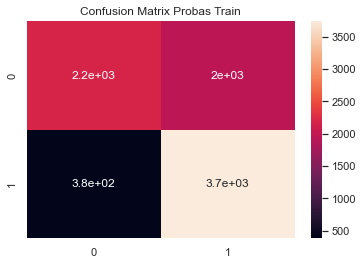

In [57]:
sns.heatmap(confusion_matrix(y_train, preds), annot=True)
plt.title('Confusion Matrix Probas Train');

En train parece que ha mejorado un poco vamos a ver en test

In [58]:
probas_test = lr.predict_proba(X_test)
preds_test = [1 if probas_test[i][1]>0.30 else 0 for i in range(len(probas_test))]
recall_proba_test = recall_score(y_test, preds_test)
precision_proba_test = precision_score(y_test, preds_test)
f1_score_proba_test = f1_score(y_test, preds_test)
print(f'Recall: {recall_proba_test},\nPrecision: {precision_proba_test},\nf1: {f1_score_proba_test}')

Recall: 0.8983957219251337,
Precision: 0.4072727272727273,
f1: 0.5604670558799


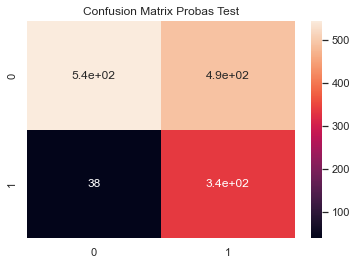

In [59]:
sns.heatmap(confusion_matrix(y_test, preds_test), annot=True)
plt.title('Confusion Matrix Probas Test');

En test no hay mejora incluso el resultado empeora del f1 empeora pero el recall ha subido, y si nos fijamos en el error Tipo 2, es decir, estamos detectando con bastante acierto los posibles clientes potenciales a dejar la compañia.

### Otros modelos de clasificación

#### Decisión tree

In [60]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [61]:
df_le.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthLevel,TotalLevel,TenureLevel,ChurnBinary
0,5365,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0,1,4,1,0.0
1,3953,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0,1,2,0,0.0
2,2558,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,1,4,1,1.0
3,5524,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0,1,2,0,0.0
4,6500,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,2,4,1,1.0


In [62]:
X = df_le.drop(['customerID','Churn','ChurnBinary'], axis=1)
y = df_le.Churn

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2, stratify=y)

In [64]:
dt = DecisionTreeClassifier()

In [65]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [66]:
preds = dt.predict(X_train)

In [67]:
precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.9959866220735786,
Precision: 0.9993288590604027,
f1: 0.9976549413735343


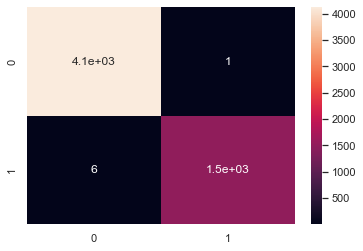

In [68]:
sns.heatmap(confusion_matrix(y_train, preds), annot=True);

In [69]:
preds_test = dt.predict(X_test)
precision_test = precision_score(y_test, preds_test)
recall_test = recall_score(y_test, preds_test)
f1_test = f1_score(y_test, preds_test)
print(f'Recall: {recall_test},\nPrecision: {precision_test},\nf1: {f1_test}')

Recall: 0.49732620320855614,
Precision: 0.465,
f1: 0.48062015503875966


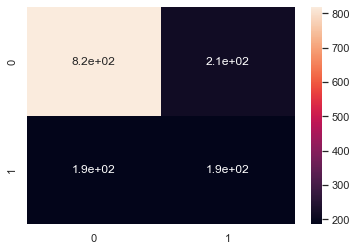

In [70]:
sns.heatmap(confusion_matrix(y_test, preds_test), annot=True);

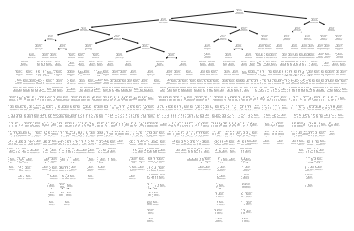

In [71]:
plot_tree(dt)
plt.show();

In [72]:
feact = dict(zip(df_le.drop(['customerID','Churn','ChurnBinary'], axis=1).columns,dt.feature_importances_))

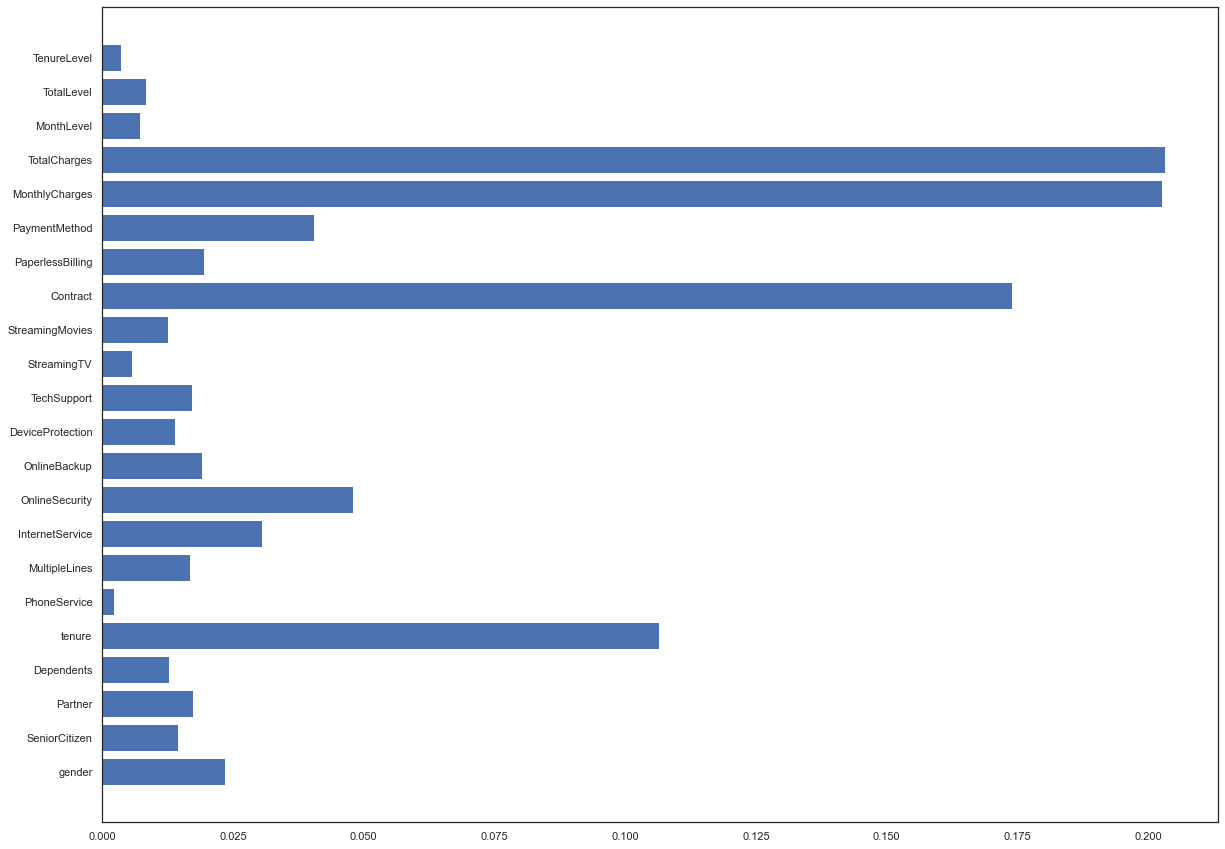

In [73]:
plt.figure(figsize=(20,15))
plt.barh(pd.DataFrame(feact, index=[0]).T[0].index, 
         width=pd.DataFrame(feact, index=[0]).T[0]);

In [74]:
g_feact = []

for k,v in feact.items():
    if v > 0.03:
        g_feact.append(k)
g_feact

['tenure',
 'InternetService',
 'OnlineSecurity',
 'Contract',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [75]:
X = df_le[g_feact]
y = df_le.Churn

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2, stratify=y)

In [77]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [78]:
preds = dt.predict(X_train)
precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.9879598662207358,
Precision: 0.9919408999328408,
f1: 0.9899463806970509


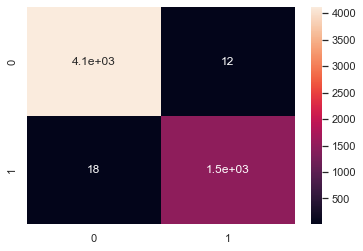

In [79]:
sns.heatmap(confusion_matrix(y_train, preds), annot=True);

In [80]:
preds_test = dt.predict(X_test)
precision_test = precision_score(y_test, preds_test)
recall_test = recall_score(y_test, preds_test)
f1_test = f1_score(y_test, preds_test)
print(f'Recall: {recall_test},\nPrecision: {precision_test},\nf1: {f1_test}')

Recall: 0.47058823529411764,
Precision: 0.4607329842931937,
f1: 0.46560846560846564


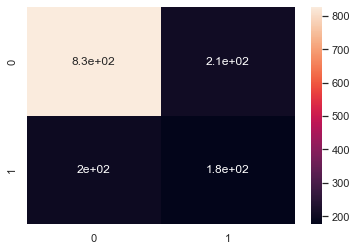

In [81]:
sns.heatmap(confusion_matrix(y_test, preds_test), annot=True);

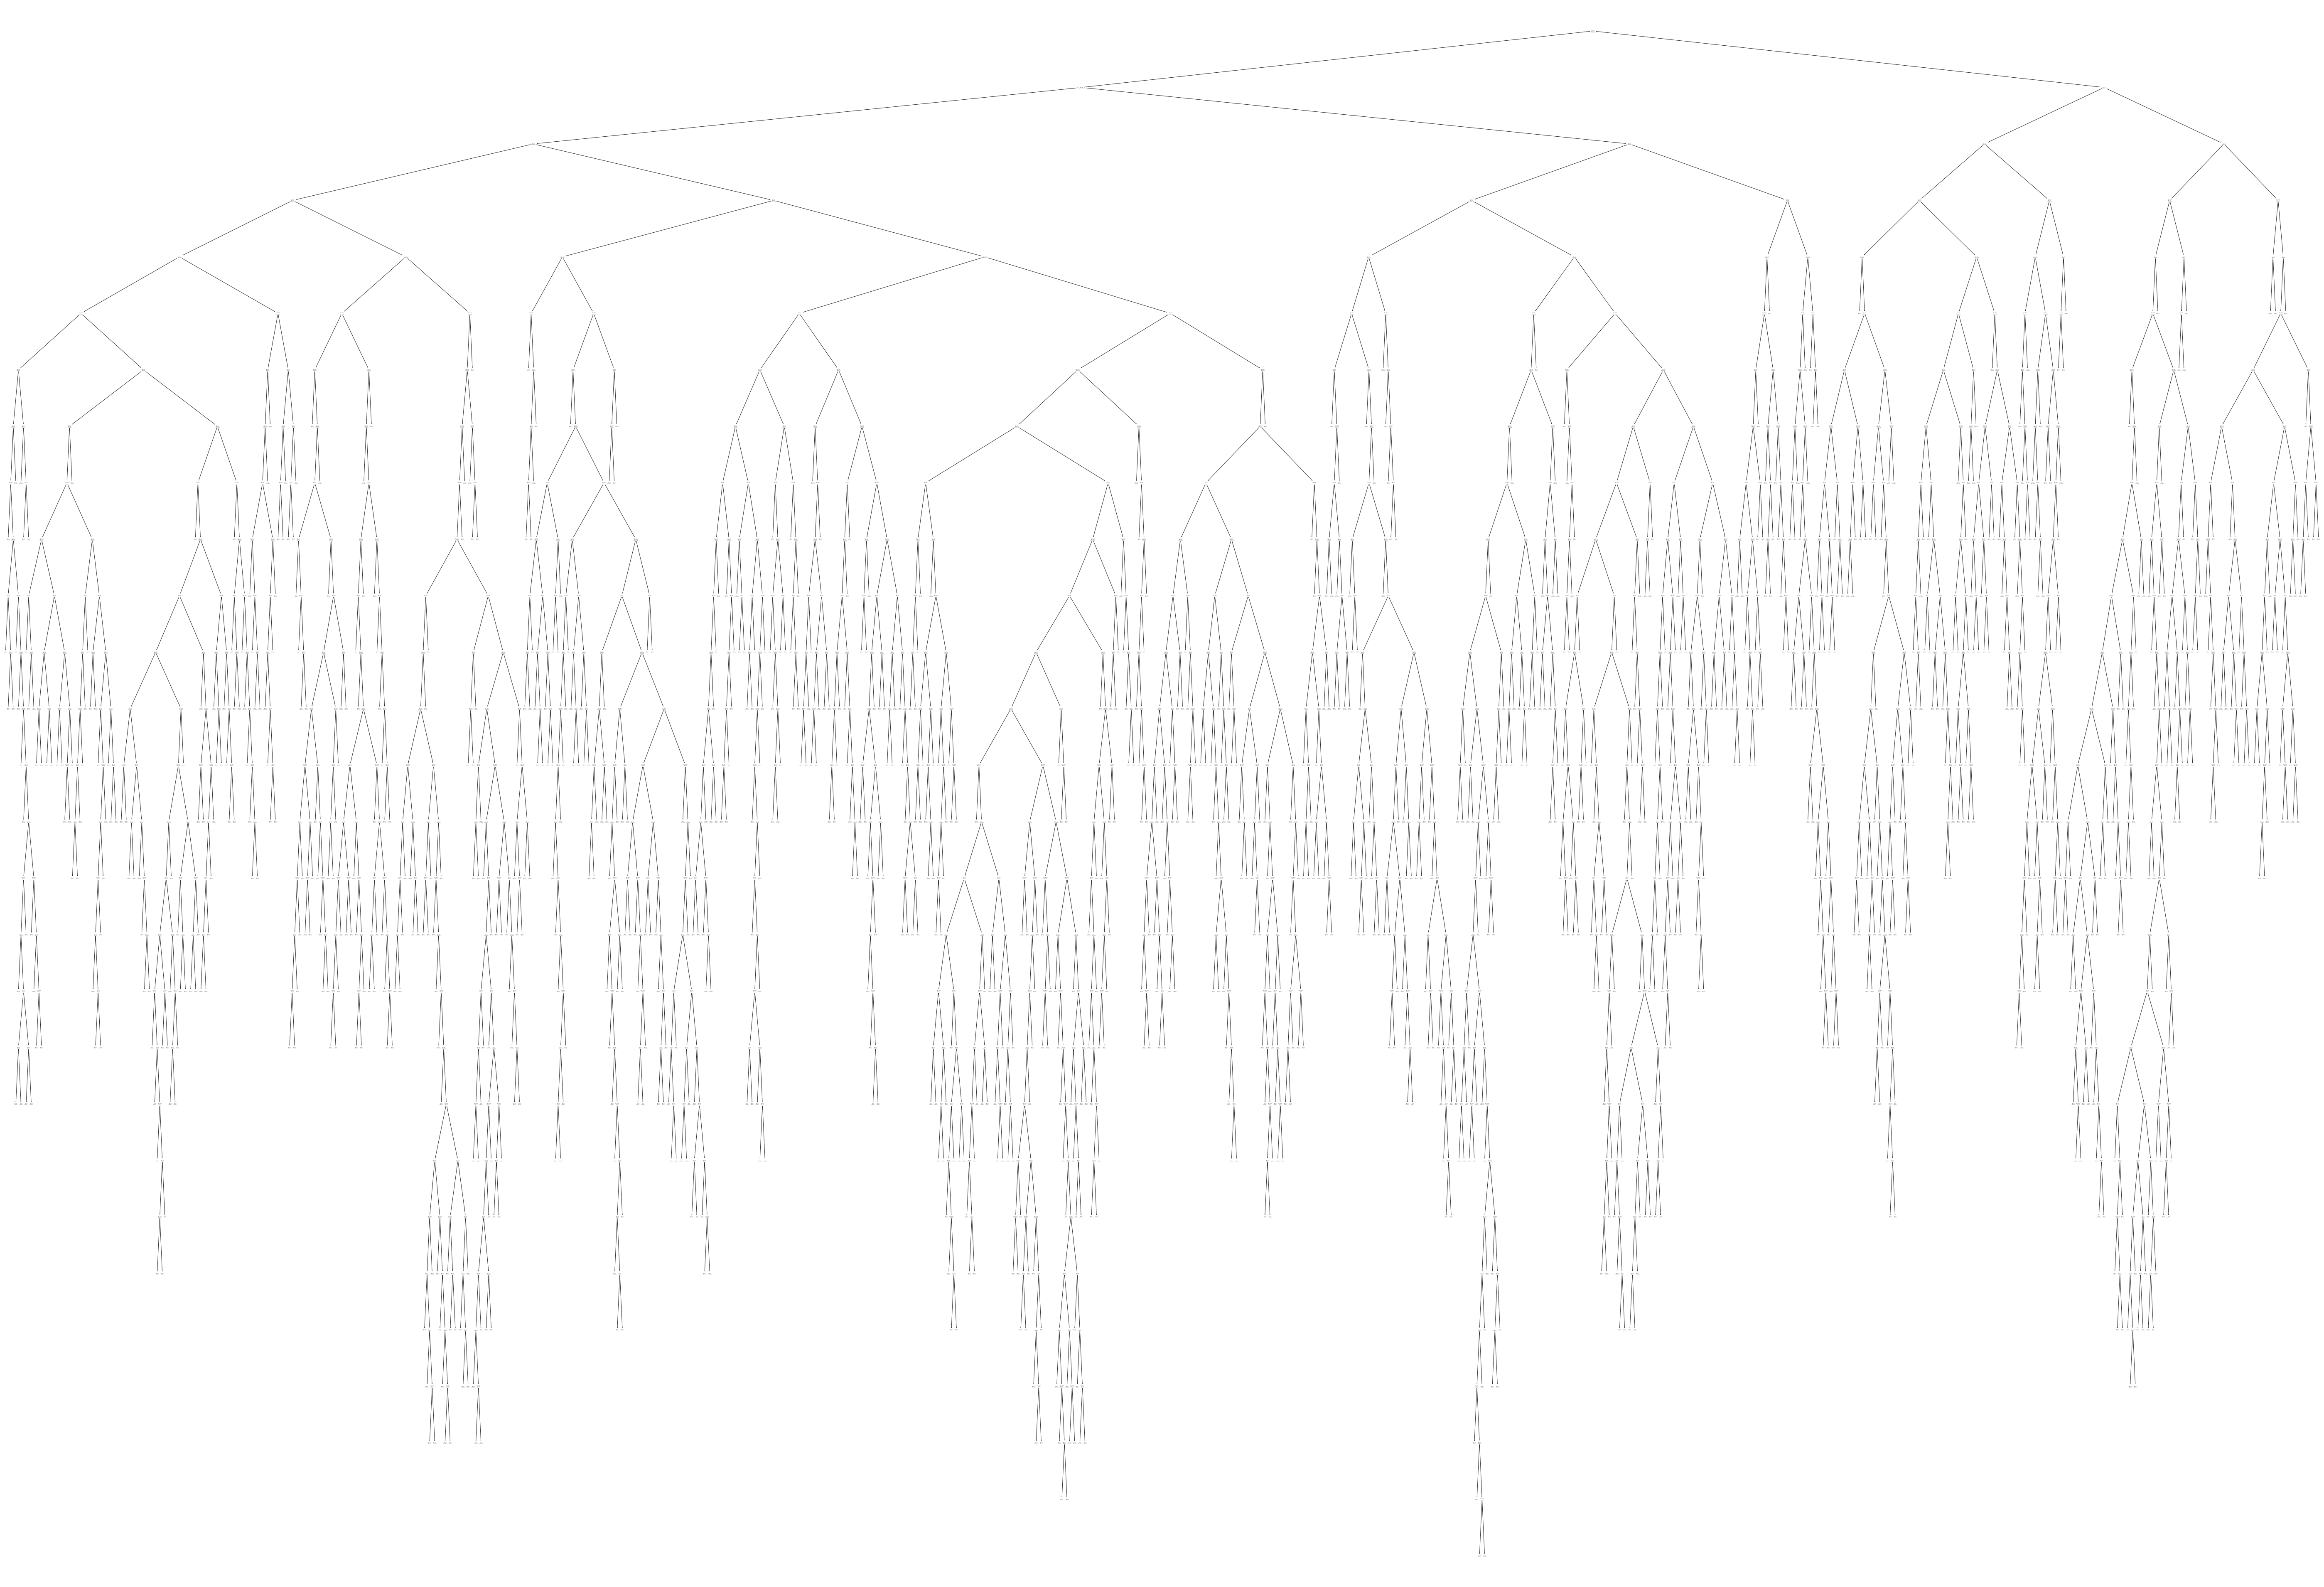

In [82]:
plt.figure(figsize=(100,70))
plot_tree(dt)
plt.show();

#### Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
X = df_le.drop(['customerID','Churn','ChurnBinary'], axis=1)
y = df_le.Churn

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2, stratify=y)

In [86]:
rf = RandomForestClassifier()
smote = SMOTE()

In [87]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [88]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [89]:
preds = rf.predict(X_train)
precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.9990314769975787,
Precision: 0.9990314769975787,
f1: 0.9990314769975787


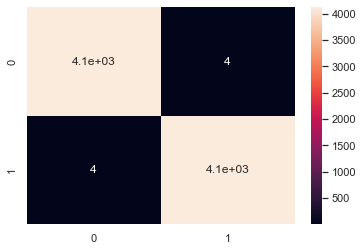

In [90]:
sns.heatmap(confusion_matrix(y_train, preds), annot=True);

In [91]:
preds_test = rf.predict(X_test)
precision_test = precision_score(y_test, preds_test)
recall_test = recall_score(y_test, preds_test)
f1_test = f1_score(y_test, preds_test)
print(f'Recall: {recall_test},\nPrecision: {precision_test},\nf1: {f1_test}')

Recall: 0.5855614973262032,
Precision: 0.5572519083969466,
f1: 0.5710560625814863


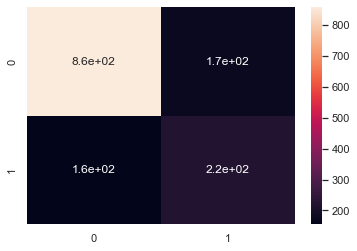

In [92]:
sns.heatmap(confusion_matrix(y_test, preds_test), annot=True);

In [93]:
feact = dict(zip(df_le.drop(['customerID','Churn','ChurnBinary'], axis=1).columns,rf.feature_importances_))

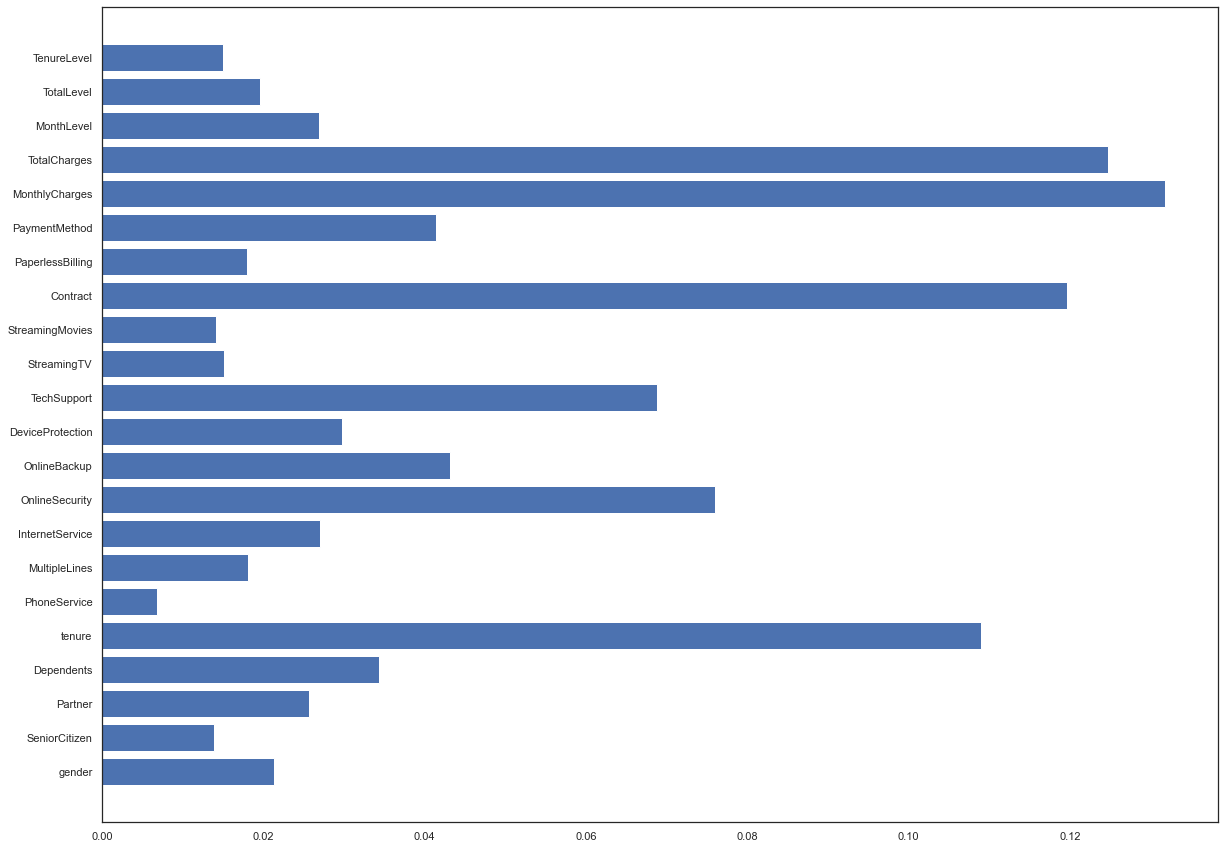

In [94]:
plt.figure(figsize=(20,15))
plt.barh(pd.DataFrame(feact, index=[0]).T[0].index, 
         width=pd.DataFrame(feact, index=[0]).T[0]);

In [95]:
g_feact = []

for k,v in feact.items():
    if v > 0.03:
        g_feact.append(k)
g_feact

['Dependents',
 'tenure',
 'OnlineSecurity',
 'OnlineBackup',
 'TechSupport',
 'Contract',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [96]:
X = df_le[g_feact]
y = df_le.Churn

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2, stratify=y)

In [98]:
rf = RandomForestClassifier()
smote = SMOTE()

In [99]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [100]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [101]:
preds = rf.predict(X_train)
precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.997820823244552,
Precision: 0.9958917351377478,
f1: 0.9968553459119496


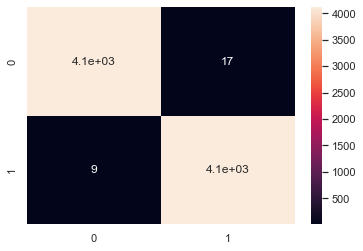

In [102]:
sns.heatmap(confusion_matrix(y_train, preds), annot=True);

In [103]:
preds_test = rf.predict(X_test)
precision_test = precision_score(y_test, preds_test)
recall_test = recall_score(y_test, preds_test)
f1_test = f1_score(y_test, preds_test)
print(f'Recall: {recall_test},\nPrecision: {precision_test},\nf1: {f1_test}')

Recall: 0.5775401069518716,
Precision: 0.5307125307125307,
f1: 0.5531370038412291


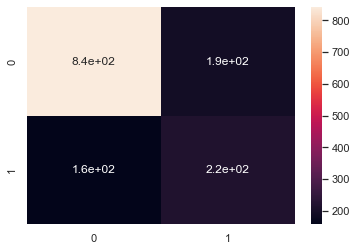

In [104]:
sns.heatmap(confusion_matrix(y_test, preds_test), annot=True);

In [105]:
proba = rf.predict_proba(X_train)
preds = [1 if probas[i][1]>0.35 else 0 for i in range(len(proba))]
precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.8547215496368039,
Precision: 0.6895878101191639,
f1: 0.763325764947562


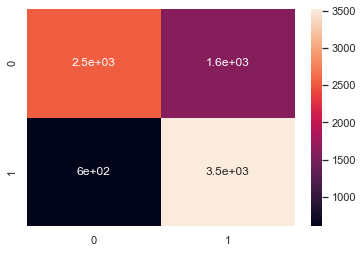

In [106]:
sns.heatmap(confusion_matrix(y_train, preds), annot=True);

In [107]:
proba = rf.predict_proba(X_test)
preds = [1 if probas[i][1]>0.18 else 0 for i in range(len(proba))]
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.7406417112299465,
Precision: 0.2618147448015123,
f1: 0.38687150837988826


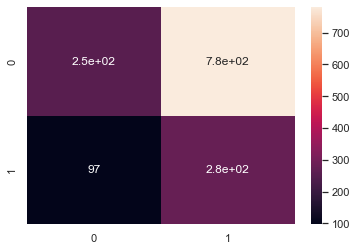

In [108]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True);

#### XGBoost

In [109]:
#!pip install xgboost

In [110]:
from xgboost import XGBRFClassifier

In [111]:
X = df_le.drop(['customerID','Churn','ChurnBinary'], axis=1)
y = df_le.Churn

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2, stratify=y)

In [113]:
xgb = XGBRFClassifier()
smote = SMOTE()

In [114]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [115]:
xgb.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='', max_bin=256,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                sampling_method='uniform', scale_pos_weight=1, ...)

In [117]:
preds = xgb.predict(X_train)
precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.8714285714285714,
Precision: 0.8201914311759344,
f1: 0.8450340455505988


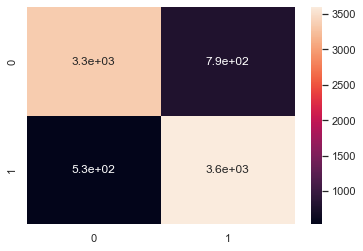

In [118]:
sns.heatmap(confusion_matrix(y_train, preds), annot=True);

In [119]:
preds_test = xgb.predict(X_test)
precision_test = precision_score(y_test, preds_test)
recall_test = recall_score(y_test, preds_test)
f1_test = f1_score(y_test, preds_test)
print(f'Recall: {recall_test},\nPrecision: {precision_test},\nf1: {f1_test}')

Recall: 0.6898395721925134,
Precision: 0.5222672064777328,
f1: 0.5944700460829494


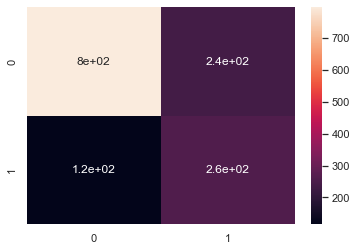

In [121]:
sns.heatmap(confusion_matrix(y_test, preds_test), annot=True);

In [122]:
xgb.feature_importances_

array([0.00757919, 0.00191915, 0.02210365, 0.04670234, 0.01639777,
       0.01067388, 0.00726104, 0.09673519, 0.10945791, 0.02753257,
       0.00550171, 0.08888556, 0.00401467, 0.00878872, 0.47299808,
       0.00437647, 0.00800787, 0.01945339, 0.01219293, 0.01766019,
       0.00687041, 0.00488735], dtype=float32)

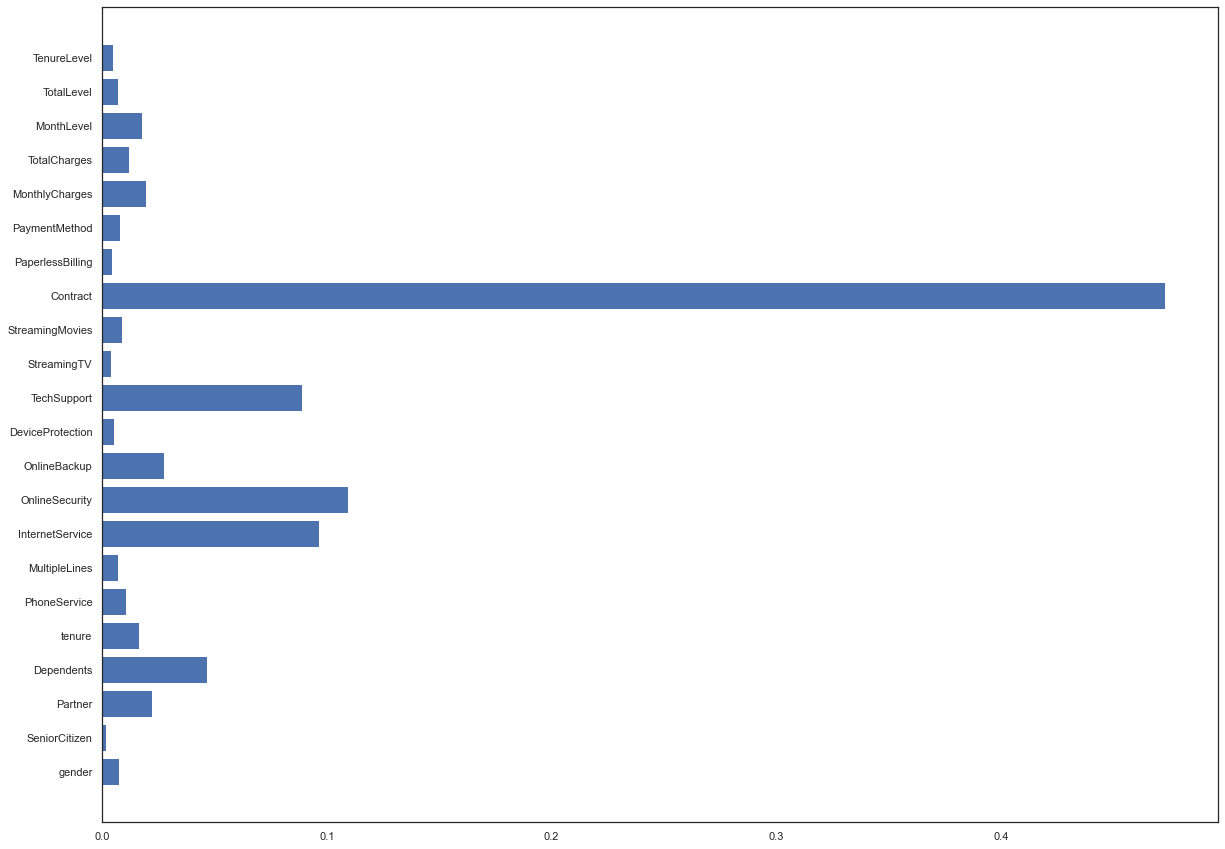

In [123]:
feact = dict(zip(df_le.drop(['customerID','Churn','ChurnBinary'], axis=1).columns,xgb.feature_importances_))
plt.figure(figsize=(20,15))
plt.barh(pd.DataFrame(feact, index=[0]).T[0].index, 
         width=pd.DataFrame(feact, index=[0]).T[0]);

In [126]:
g_feact = []

for k,v in feact.items():
    if v > 0.02:
        g_feact.append(k)
g_feact

['Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'TechSupport',
 'Contract']

In [127]:
X = df_le[g_feact]
y = df_le.Churn

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2, stratify=y)

In [129]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [130]:
xgb.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='', max_bin=256,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                sampling_method='uniform', scale_pos_weight=1, ...)

In [131]:
preds = xgb.predict(X_train)
precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.8130750605326876,
Precision: 0.7458907152376721,
f1: 0.778035217794254


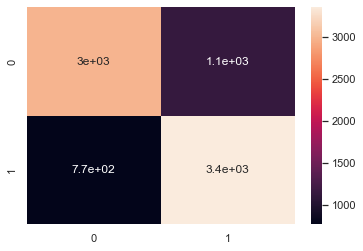

In [132]:
sns.heatmap(confusion_matrix(y_train, preds), annot=True);

In [133]:
preds_test = xgb.predict(X_test)
precision_test = precision_score(y_test, preds_test)
recall_test = recall_score(y_test, preds_test)
f1_test = f1_score(y_test, preds_test)
print(f'Recall: {recall_test},\nPrecision: {precision_test},\nf1: {f1_test}')

Recall: 0.7647058823529411,
Precision: 0.47906197654941374,
f1: 0.5890834191555098


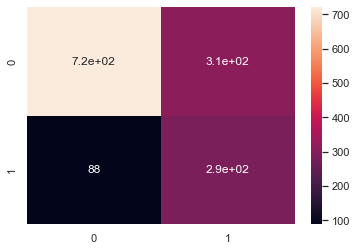

In [134]:
sns.heatmap(confusion_matrix(y_test, preds_test), annot=True);

In [155]:
proba = xgb.predict_proba(X_test)
preds = [1 if probas[i][1]>0.17 else 0 for i in range(len(proba))]
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(f'Recall: {recall},\nPrecision: {precision},\nf1: {f1}')

Recall: 0.767379679144385,
Precision: 0.26476014760147604,
f1: 0.3936899862825789


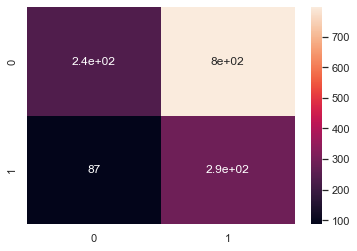

In [156]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True);

Para finalizar podemos corroborar que este tipo de problematica es compleja de solucionar y al final comprobamos que no por usar modelos más complejos vamos a obtener mejores resultados, en este caso el modelo con el que mejores resultados hemos obtenido de forma general ha sido la regresión logística ajustando el umbral de decisión, ya que disminuíamos el número de Falsos Negativos, y por lo tanto la fuga de clientes sin identificar es menor.